In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [13]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),                  # 调整图像大小为28x28
    transforms.ToTensor(),                        # 转换为Tensor
])

In [14]:
# 加载训练集数据
train_dataset = datasets.MNIST(
    root='./data',  # 数据存储的路径
    train=True,  # 表示加载训练数据集
    download=True,  # 如果数据集没有下载，会自动下载
    transform=transform  # 对数据应用transform操作，例如转换为Tensor
)

# 加载测试集数据，MNIST数据集的测试部分，train=False表示加载测试集
test_dataset = datasets.MNIST(
    root='./data',  # 数据存储的路径
    train=False,  # 表示加载测试数据集
    download=True,  # 如果数据集没有下载，会自动下载
    transform=transform  # 对数据应用transform操作，例如转换为Tensor
)

7


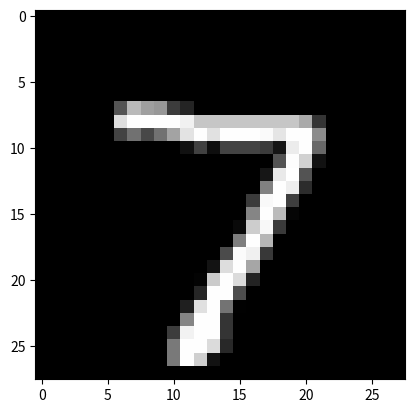

In [15]:
img, label = test_dataset[0]
img = img.permute(1, 2, 0)  #  Tensor，转换成 (H, W, C) 格式
plt.imshow(img, cmap='gray') 
print(label)

In [16]:
# 使用DataLoader来加载训练数据

train_loader = DataLoader(
    train_dataset,  # 传入训练数据集
    batch_size=32,  # 批次数量
    shuffle=True,  # 打乱数据
    num_workers=8  # 加载数据进程数
)

test_loader = DataLoader(
    test_dataset,  # 传入测试数据集
    batch_size=32,  # 每批次数量
    shuffle=False,  # 不打乱数据
    num_workers=8  # 加载数据进程数
)

In [17]:
# 检查是否有可用的GPU，如果有就使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 定义LeNet-5网络结构
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        # 第一层卷积层：输入1通道，输出6通道，卷积核5x5，padding=same
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        # 第一层池化层：2x2平均池化
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        # 第二层卷积层：输入6通道，输出16通道，卷积核5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # 第二层池化层：2x2平均池化
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        # 第三层卷积层：输入16通道，输出120通道，卷积核5x5
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        # 展平层
        self.flatten = nn.Flatten()
        # 全连接层：输入120，输出84
        self.fc1 = nn.Linear(120, 84)
        # 全连接层：输入84，输出10（对应10个类别）
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # 第一层卷积 + 激活 + 池化
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        # 第二层卷积 + 激活 + 池化
        x = torch.sigmoid(self.conv2(x))
        x = self.pool2(x)
        # 第三层卷积 + 激活
        x = torch.sigmoid(self.conv3(x))
        # 展平
        x = self.flatten(x)  # 使用 flatten 层
        # 全连接层 + 激活
        x = torch.sigmoid(self.fc1(x))
        # 输出层
        x = self.fc2(x)
        return x

In [19]:
model = LeNet5().to(device)# 初始化模型，并将模型移至 GPU（如果可用）
criterion = nn.CrossEntropyLoss()  # 分类任务使用交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001) #设置优化器

In [20]:
def compute_accuracy(loader, device):
    correct = 0  # 初始化正确预测的数
    total = 0    # 初始化总的样本数
    with torch.no_grad():  # 不需计算梯度，这样可以节省内存和计算资源
        for inputs, labels in loader:# 遍历数据加载器中的每一个 batch
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签转移到指定的设备
            outputs = model(inputs)  # 用当前的模型进行前向传播，得到预测结果
            max_values, predicted = torch.max(outputs, 1)  # 对每个输出的预测结果，找到最大值对应的索引，返回预测的类标签
            total += labels.size(0)  # 更新总样本数， labels.size(0) 是当前 batch 的样本数
            correct += (predicted == labels).sum().item()  # 统计预测正确的样本
    accuracy = 100 * correct / total  # 计算准确率
    return accuracy  # 返回计算得到的准确率

In [21]:
num_epochs = 5  # 设置训练的总轮数

for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    total_loss = 0  # 记录当前 epoch 的总损失
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # 清除之前计算的梯度
        outputs = model(inputs)  # 进行前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新参数
        total_loss += loss.item()  # 累加损失
    
    # 打印损失
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
    # 打印训练集和测试集的准确率
    train_accuracy = compute_accuracy(train_loader, device)
    test_accuracy = compute_accuracy(test_loader, device)
    print(f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/5], Loss: 0.7918
Train Accuracy: 92.68%, Test Accuracy: 92.88%
Epoch [2/5], Loss: 0.1869
Train Accuracy: 95.24%, Test Accuracy: 95.33%
Epoch [3/5], Loss: 0.1246
Train Accuracy: 96.83%, Test Accuracy: 96.81%
Epoch [4/5], Loss: 0.0945
Train Accuracy: 97.66%, Test Accuracy: 97.66%
Epoch [5/5], Loss: 0.0764
Train Accuracy: 98.06%, Test Accuracy: 98.07%


In [22]:
torch.save(model.state_dict(), 'lenet5.pth') #保存模型
print("模型已保存为 lenet5.pth")

模型已保存为 lenet5.pth
